In [1]:
!pip install -q torch transformers datasets accelerate

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [30]:

train_dataset = load_dataset("imdb", split="train")
test_dataset = load_dataset("imdb", split="test")

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

train_labels = [train_dataset[i]['label'] for i in range(min(10000, len(train_dataset)))]
print(f"   Training class distribution (first 10k):")
print(f"   Positive (1): {sum(train_labels)}")
print(f"   Negative (0): {len(train_labels) - sum(train_labels)}")


def get_balanced_subset(dataset, n_samples_per_class=2000):

    positive_indices = []
    negative_indices = []

    for i in range(len(dataset)):
        if dataset[i]['label'] == 1 and len(positive_indices) < n_samples_per_class:
            positive_indices.append(i)
        elif dataset[i]['label'] == 0 and len(negative_indices) < n_samples_per_class:
            negative_indices.append(i)

        if len(positive_indices) == n_samples_per_class and len(negative_indices) == n_samples_per_class:
            break

    balanced_indices = positive_indices + negative_indices
    np.random.shuffle(balanced_indices)

    balanced_data = [dataset[i] for i in balanced_indices]
    return balanced_data


balanced_train_data = get_balanced_subset(train_dataset, n_samples_per_class=2000)
balanced_test_data = get_balanced_subset(test_dataset, n_samples_per_class=500)

print(f"Balanced training size: {len(balanced_train_data)}")
print(f"Balanced test size: {len(balanced_test_data)}")

train_labels_balanced = [item['label'] for item in balanced_train_data]
print(f"   Balanced class distribution:")
print(f"   Positive (1): {sum(train_labels_balanced)}")
print(f"   Negative (0): {len(train_labels_balanced) - sum(train_labels_balanced)}")

Training dataset size: 25000
Test dataset size: 25000
   Training class distribution (first 10k):
   Positive (1): 0
   Negative (0): 10000
Balanced training size: 4000
Balanced test size: 1000
   Balanced class distribution:
   Positive (1): 2000
   Negative (0): 2000


In [31]:
train_size = int(0.8 * len(balanced_train_data))
val_size = len(balanced_train_data) - train_size

train_data = balanced_train_data[:train_size]
val_data = balanced_train_data[train_size:]

print(f"\n Final splits:")
print(f"   Training: {len(train_data)} samples")
print(f"   Validation: {len(val_data)} samples")
print(f"   Test: {len(balanced_test_data)} samples")


 Final splits:
   Training: 3200 samples
   Validation: 800 samples
   Test: 1000 samples


In [32]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to(device)

print("\nModel loaded successfully")

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Model loaded successfully


In [33]:
class IMDbDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = self.data[idx]['label']

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [25]:
train_dataset_obj = IMDbDataset(train_data, tokenizer)
val_dataset_obj = IMDbDataset(val_data, tokenizer)
test_dataset_obj = IMDbDataset(balanced_test_data, tokenizer)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset_obj, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_obj, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset_obj, batch_size=BATCH_SIZE)

print(f"\n Batch size: {BATCH_SIZE}")
print(f"   Training batches: {len(train_loader)}")


 Batch size: 16
   Training batches: 200


In [34]:
def train_model(model, train_loader, val_loader, epochs=3):
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )



    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        model.train()
        epoch_loss = 0

        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)

                all_predictions.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions)
        val_accuracies.append(accuracy)

        print(f"\nTraining Loss: {avg_loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.4f}")


        if epoch == epochs - 1:
            cm = confusion_matrix(all_labels, all_predictions)
            print(f"\n Confusion Matrix (Validation):")
            print(f"        Predicted")
            print(f"        Neg  Pos")
            print(f"True Neg {cm[0][0]:4d} {cm[0][1]:4d}")
            print(f"True Pos {cm[1][0]:4d} {cm[1][1]:4d}")


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, marker='o', linewidth=2)
    plt.title('Training Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, marker='s', color='green', linewidth=2)
    plt.title('Validation Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim([0, 1.0])
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return train_losses, val_accuracies

Epoch 1/3


Validation: 100%|██████████| 50/50 [01:48<00:00,  2.17s/it]



Training Loss: 0.5072
Validation Accuracy: 0.8475
Epoch 2/3


Validation: 100%|██████████| 50/50 [01:50<00:00,  2.20s/it]



Training Loss: 0.2822
Validation Accuracy: 0.8712
Epoch 3/3


Validation: 100%|██████████| 50/50 [01:49<00:00,  2.19s/it]



Training Loss: 0.1742
Validation Accuracy: 0.8675

 Confusion Matrix (Validation):
        Predicted
        Neg  Pos
True Neg  320   46
True Pos   60  374


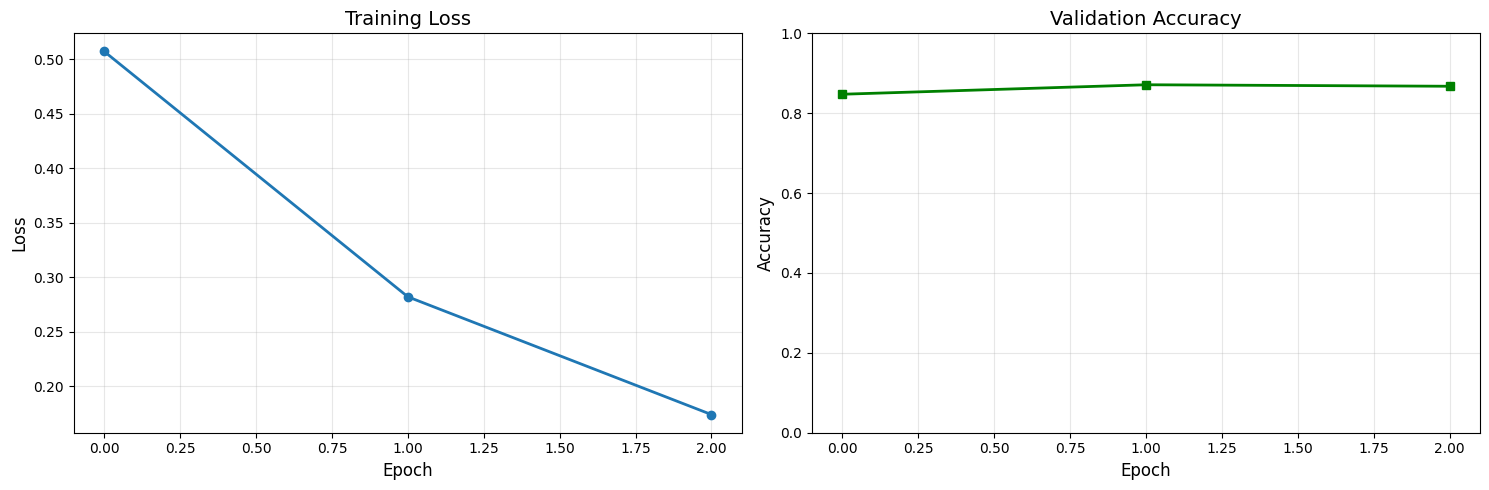

In [35]:
train_losses, val_accuracies = train_model(model, train_loader, val_loader, epochs=3)

In [36]:
def test_model(model, test_loader):

    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)

    print(f"\n Test Set Results:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"\n Confusion Matrix (Test):")
    print(f"        Predicted")
    print(f"        Neg  Pos")
    print(f"True Neg {cm[0][0]:4d} {cm[0][1]:4d}")
    print(f"True Pos {cm[1][0]:4d} {cm[1][1]:4d}")

    print(f"\n Classification Report:")
    print(classification_report(all_labels, all_predictions,
                               target_names=['Negative', 'Positive']))

    return accuracy, all_predictions, all_labels, all_probs

print("TESTING ON UNSEEN TEST DATA")
test_accuracy, test_preds, test_labels, test_probs = test_model(model, test_loader)


TESTING ON UNSEEN TEST DATA


Testing: 100%|██████████| 63/63 [02:22<00:00,  2.27s/it]


 Test Set Results:
   Accuracy: 0.8570

 Confusion Matrix (Test):
        Predicted
        Neg  Pos
True Neg  409   91
True Pos   52  448

 Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.82      0.85       500
    Positive       0.83      0.90      0.86       500

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



In [37]:
def predict_sentiment(text):

    model.eval()
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_class].item()
        pos_prob = probs[0][1].item()
        neg_prob = probs[0][0].item()

    sentiment = "Positive" if pred_class == 1 else "Negative"
    return sentiment, confidence, pos_prob, neg_prob


test_samples = [

    "This movie was absolutely fantastic! The acting was superb and the story was captivating from beginning to end.",
    "One of the best movies I've seen in years! Highly recommended to everyone.",
    "An amazing cinematic experience with breathtaking visuals and emotional depth.",
    "I loved every minute of it! The characters were well-developed and the plot was engaging.",
    "A masterpiece of modern cinema. The director's vision was perfectly executed.",

    "Terrible film, complete waste of time. I regret watching it.",
    "Boring and predictable storyline with bad acting. Couldn't wait for it to end.",
    "The movie had some good moments but overall was disappointing.",
    "Worst movie ever. Don't waste your money on this.",
    "I found the plot confusing and the characters uninteresting.",

    "It was okay, nothing special but not bad either. Average movie.",
    "The film had potential but failed to deliver. Some good scenes though.",
    "Not great, not terrible. Just an average viewing experience."
]

for i, text in enumerate(test_samples):
    sentiment, confidence, pos_prob, neg_prob = predict_sentiment(text)

    print(f"\n Sample {i+1}:")
    print(f"   Text: {text[:70]}...")
    print(f"   Prediction: {sentiment}")
    print(f"   Confidence: {confidence:.2%}")
    print(f"   Positive prob: {pos_prob:.2%}")
    print(f"   Negative prob: {neg_prob:.2%}")


 Sample 1:
   Text: This movie was absolutely fantastic! The acting was superb and the sto...
   Prediction: Positive
   Confidence: 98.80%
   Positive prob: 98.80%
   Negative prob: 1.20%

 Sample 2:
   Text: One of the best movies I've seen in years! Highly recommended to every...
   Prediction: Positive
   Confidence: 98.73%
   Positive prob: 98.73%
   Negative prob: 1.27%

 Sample 3:
   Text: An amazing cinematic experience with breathtaking visuals and emotiona...
   Prediction: Positive
   Confidence: 98.71%
   Positive prob: 98.71%
   Negative prob: 1.29%

 Sample 4:
   Text: I loved every minute of it! The characters were well-developed and the...
   Prediction: Positive
   Confidence: 98.64%
   Positive prob: 98.64%
   Negative prob: 1.36%

 Sample 5:
   Text: A masterpiece of modern cinema. The director's vision was perfectly ex...
   Prediction: Positive
   Confidence: 98.54%
   Positive prob: 98.54%
   Negative prob: 1.46%

 Sample 6:
   Text: Terrible film, complete waste